<a href="https://colab.research.google.com/github/brndiogo/brndiogo-iIoT-Garbage-Management-Monitoring-and-Acknowledgment-System-Review/blob/main/Colab_Teste3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# 1. Instala a biblioteca do Kaggle
!pip install kaggle

# 2. Pede para você fazer o upload do seu arquivo kaggle.json
from google.colab import files
print("--- Por favor, faça o upload do seu arquivo kaggle.json ---")
files.upload()

# 3. Configura o arquivo kaggle.json no lugar certo
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# 4. Baixa o Dataset "Garbage Classification (12 classes)" (~15k imagens)
print("\n--- Baixando o dataset 'mostafaabla/garbage-classification'... ---")
!kaggle datasets download -d mostafaabla/garbage-classification

# 5. Descompacta o dataset
# (Ele cria uma pasta 'garbage classification 12 classes/garbage classification')
print("--- Descompactando arquivos... ---")
!unzip -q garbage-classification.zip

print("\n--- PRONTO! O dataset está em /content/garbage classification 12 classes/ ---")

--- Por favor, faça o upload do seu arquivo kaggle.json ---


Saving kaggle.json to kaggle.json

--- Baixando o dataset 'mostafaabla/garbage-classification'... ---
Dataset URL: https://www.kaggle.com/datasets/mostafaabla/garbage-classification
License(s): ODbL-1.0
 61% 147M/239M [00:00<00:00, 1.53GB/s]
100% 239M/239M [00:00<00:00, 919MB/s] 
--- Descompactando arquivos... ---

--- PRONTO! O dataset está em /content/garbage classification 12 classes/ ---


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

# --- 1. Configuração do Experimento ---
IMG_WIDTH = 128
IMG_HEIGHT = 128
NUM_CLASSES = 12  # MUDANÇA: Agora temos 12 classes
BATCH_SIZE = 32
TOTAL_EPOCHS = 50 # 50 épocas para um dataset maior é bom

# MUDANÇA: Corrigimos o caminho para a pasta interna
DATA_PATH = 'garbage classification 12 classes/garbage classification'

# --- 2. Carregar os Dados Reais ---
# (Este dataset também não tem split, então usamos validation_split 80/20)

print("--- Carregando dataset de TREINO (80%)... ---")
train_dataset = tf.keras.utils.image_dataset_from_directory(
    DATA_PATH,
    image_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    label_mode='int',
    validation_split=0.2,  # 20% para validação
    subset='training',
    seed=123
)

print("--- Carregando dataset de VALIDAÇÃO (20%)... ---")
val_dataset = tf.keras.utils.image_dataset_from_directory(
    DATA_PATH,
    image_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    label_mode='int',
    validation_split=0.2,
    subset='validation',
    seed=123
)

# Otimização (cache e prefetch)
train_dataset = train_dataset.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
val_dataset = val_dataset.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

STEPS_PER_EPOCH = len(train_dataset)


# --- 3. Função para Criar o Modelo (Estratégia de Fine-Tuning) ---

# Camada de "Aumento de Dados"
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
  layers.RandomZoom(0.2),
])

def criar_modelo():
    # Usamos 'imagenet'
    base_modelo = tf.keras.applications.MobileNetV2(
        input_shape=(IMG_WIDTH, IMG_HEIGHT, 3),
        include_top=False,
        weights='imagenet'
    )
    # Permitimos o Fine-Tuning
    base_modelo.trainable = True

    # Congelamos as primeiras 100 camadas
    fine_tune_at = 100
    for layer in base_modelo.layers[:fine_tune_at]:
        layer.trainable = False

    modelo = tf.keras.Sequential([
        layers.Rescaling(1./255),
        data_augmentation,
        base_modelo,
        layers.GlobalAveragePooling2D(),
        layers.Dropout(0.4), # Regularização
        layers.Dense(NUM_CLASSES, activation='softmax') # Automaticamente 12 classes
    ])
    return modelo

# --- 4. Experimento A: "Rampa" (Step Decay) ---
print("\n--- Iniciando Experimento A (RAMPA / STEP DECAY) ---")

modelo_rampa = criar_modelo()

# Usamos a taxa de aprendizado BAIXA para Fine-Tuning
lr_schedule_rampa = tf.keras.optimizers.schedules.PiecewiseConstantDecay(
    boundaries=[STEPS_PER_EPOCH * 20, STEPS_PER_EPOCH * 40],
    values=[0.0001, 0.00005, 0.00001]
)

modelo_rampa.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule_rampa),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history_rampa = modelo_rampa.fit(
    train_dataset,
    epochs=TOTAL_EPOCHS,
    validation_data=val_dataset
)


# --- 5. Experimento B: "Cosseno" (Cosine Decay) ---
print("\n--- Iniciando Experimento B (COSSENO / COSINE DECAY) ---")

modelo_cosseno = criar_modelo() # CRÍTICO: Crie um modelo novo!

total_decay_steps = STEPS_PER_EPOCH * TOTAL_EPOCHS

# Usamos a taxa de aprendizado BAIXA para Fine-Tuning
lr_schedule_cosseno = tf.keras.optimizers.schedules.CosineDecay(
    initial_learning_rate=0.0001, # Mesmo valor inicial
    decay_steps=total_decay_steps
)

modelo_cosseno.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule_cosseno),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history_cosseno = modelo_cosseno.fit(
    train_dataset,
    epochs=TOTAL_EPOCHS,
    validation_data=val_dataset
)


# --- 6. Análise: Plotar os Gráficos ---
print("\n--- Plotando Resultados (A Análise) ---")

acc_rampa = history_rampa.history['val_accuracy']
acc_cosseno = history_cosseno.history['val_accuracy']
epocas = range(1, TOTAL_EPOCHS + 1)

plt.figure(figsize=(12, 6))
plt.plot(epocas, acc_rampa, 'b--', label='Acurácia (Rampa / Step Decay)')
plt.plot(epocas, acc_cosseno, 'r-', label='Acurácia (Cosseno / Cosine Decay)')
plt.title('Resultado: Rampa vs. Cosseno (Dataset Grande - 15k imagens)')
plt.xlabel('Épocas')
plt.ylabel('Acurácia na Validação')
plt.legend()
plt.grid(True)
plt.show()

print(f"Acurácia final (Rampa):   {acc_rampa[-1]:.4f}")
print(f"Acurácia final (Cosseno): {acc_cosseno[-1]:.4f}")

--- Carregando dataset de TREINO (80%)... ---


NotFoundError: Could not find directory garbage classification 12 classes/garbage classification

--- Carregando dataset de TREINO (80%)... ---
Found 15515 files belonging to 12 classes.
Using 12412 files for training.
--- Carregando dataset de VALIDAÇÃO (20%)... ---
Found 15515 files belonging to 12 classes.
Using 3103 files for validation.

--- Iniciando Experimento A (RAMPA / STEP DECAY) ---
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/50
388/388 ━━━━━━━━━━━━━━━━━━━━ 45s 72ms/step - accuracy: 0.5924 - loss: 1.3326 - val_accuracy: 0.6900 - val_loss: 1.0031
Epoch 2/50
388/388 ━━━━━━━━━━━━━━━━━━━━ 18s 47ms/step - accuracy: 0.8424 - loss: 0.4984 - val_accuracy: 0.7796 - val_loss: 0.7311
Epoch 3/50
388/388 ━━━━━━━━━━━━━━━━━━━━ 18s 46ms/step - accuracy: 0.8787 - loss: 0.3606 - val_accuracy: 0.8605 - val_loss: 0.4893
Epoch 4/50
388/388 ━━━━━━━━━━━━━━━━━━━━ 18s 47ms/step - accuracy: 0.8947 - loss: 0.3185 - val_accuracy: 0.8949 - val_loss: 0.3856
Epoch 5/50
388/388 ━━━━━━━━━━━━━━━━━━━━ 18s 46ms/step - accuracy: 0.9114 - loss: 0.2708 - val_accuracy: 0.8659 - val_loss: 0.4568
E

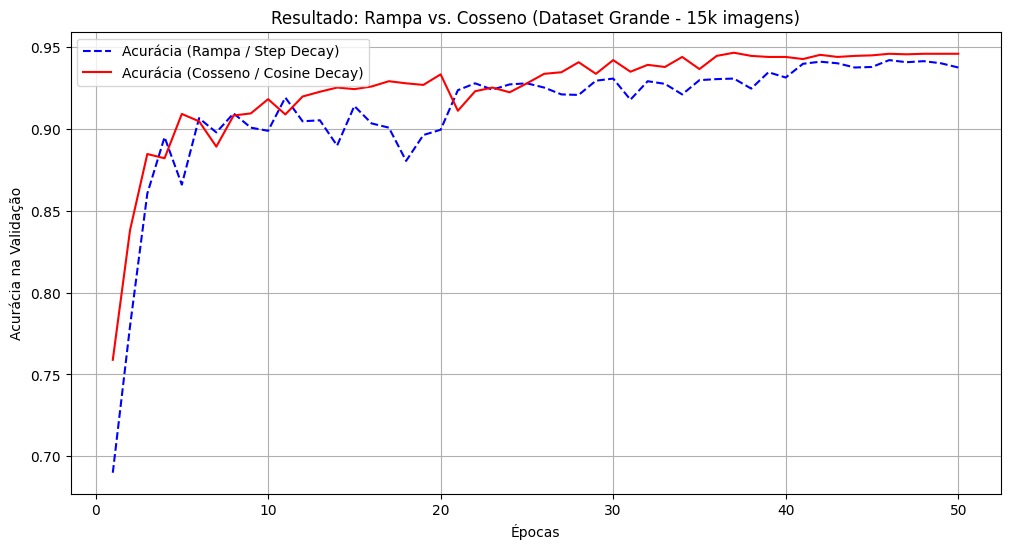

Acurácia final (Rampa):   0.9375
Acurácia final (Cosseno): 0.9459


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

# --- 1. Configuração do Experimento ---
IMG_WIDTH = 128
IMG_HEIGHT = 128
NUM_CLASSES = 12  # 12 classes
BATCH_SIZE = 32
TOTAL_EPOCHS = 50

# MUDANÇA (A CORREÇÃO):
# O caminho para as 12 classes é a pasta que você encontrou:
DATA_PATH = 'garbage_classification'

# --- 2. Carregar os Dados Reais ---
print("--- Carregando dataset de TREINO (80%)... ---")
train_dataset = tf.keras.utils.image_dataset_from_directory(
    DATA_PATH,
    image_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    label_mode='int',
    validation_split=0.2,  # 20% para validação
    subset='training',
    seed=123
)

print("--- Carregando dataset de VALIDAÇÃO (20%)... ---")
val_dataset = tf.keras.utils.image_dataset_from_directory(
    DATA_PATH,
    image_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    label_mode='int',
    validation_split=0.2,
    subset='validation',
    seed=123
)

# Otimização (cache e prefetch)
train_dataset = train_dataset.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
val_dataset = val_dataset.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

STEPS_PER_EPOCH = len(train_dataset)


# --- 3. Função para Criar o Modelo (Estratégia de Fine-Tuning) ---

# Camada de "Aumento de Dados"
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
  layers.RandomZoom(0.2),
])

def criar_modelo():
    # Usamos 'imagenet'
    base_modelo = tf.keras.applications.MobileNetV2(
        input_shape=(IMG_WIDTH, IMG_HEIGHT, 3),
        include_top=False,
        weights='imagenet'
    )
    # Permitimos o Fine-Tuning
    base_modelo.trainable = True

    # Congelamos as primeiras 100 camadas
    fine_tune_at = 100
    for layer in base_modelo.layers[:fine_tune_at]:
        layer.trainable = False

    modelo = tf.keras.Sequential([
        layers.Rescaling(1./255),
        data_augmentation,
        base_modelo,
        layers.GlobalAveragePooling2D(),
        layers.Dropout(0.4), # Regularização
        layers.Dense(NUM_CLASSES, activation='softmax') # Automaticamente 12 classes
    ])
    return modelo

# --- 4. Experimento A: "Rampa" (Step Decay) ---
print("\n--- Iniciando Experimento A (RAMPA / STEP DECAY) ---")

modelo_rampa = criar_modelo()

# Usamos a taxa de aprendizado BAIXA para Fine-Tuning
lr_schedule_rampa = tf.keras.optimizers.schedules.PiecewiseConstantDecay(
    boundaries=[STEPS_PER_EPOCH * 20, STEPS_PER_EPOCH * 40],
    values=[0.0001, 0.00005, 0.00001]
)

modelo_rampa.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule_rampa),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history_rampa = modelo_rampa.fit(
    train_dataset,
    epochs=TOTAL_EPOCHS,
    validation_data=val_dataset
)


# --- 5. Experimento B: "Cosseno" (Cosine Decay) ---
print("\n--- Iniciando Experimento B (COSSENO / COSINE DECAY) ---")

modelo_cosseno = criar_modelo() # CRÍTICO: Crie um modelo novo!

total_decay_steps = STEPS_PER_EPOCH * TOTAL_EPOCHS

# Usamos a taxa de aprendizado BAIXA para Fine-Tuning
lr_schedule_cosseno = tf.keras.optimizers.schedules.CosineDecay(
    initial_learning_rate=0.0001, # Mesmo valor inicial
    decay_steps=total_decay_steps
)

modelo_cosseno.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule_cosseno),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history_cosseno = modelo_cosseno.fit(
    train_dataset,
    epochs=TOTAL_EPOCHS,
    validation_data=val_dataset
)


# --- 6. Análise: Plotar os Gráficos ---
print("\n--- Plotando Resultados (A Análise) ---")

acc_rampa = history_rampa.history['val_accuracy']
acc_cosseno = history_cosseno.history['val_accuracy']
epocas = range(1, TOTAL_EPOCHS + 1)

plt.figure(figsize=(12, 6))
plt.plot(epocas, acc_rampa, 'b--', label='Acurácia (Rampa / Step Decay)')
plt.plot(epocas, acc_cosseno, 'r-', label='Acurácia (Cosseno / Cosine Decay)')
plt.title('Resultado: Rampa vs. Cosseno (Dataset Grande - 15k imagens)')
plt.xlabel('Épocas')
plt.ylabel('Acurácia na Validação')
plt.legend()
plt.grid(True)
plt.show()

print(f"Acurácia final (Rampa):   {acc_rampa[-1]:.4f}")
print(f"Acurácia final (Cosseno): {acc_cosseno[-1]:.4f}")